# Instrumental Noise

We extend our analysis by introducing instrumental noise into the power spectra and examining the resulting deviation from the ideal case.

### Computing the Amplitude of the Noise Power Spectra

The power spectra can be computed from the covariance of $a_{lm}^{\text noise}$, using Eq. (27) from Llyod Knox 1995:

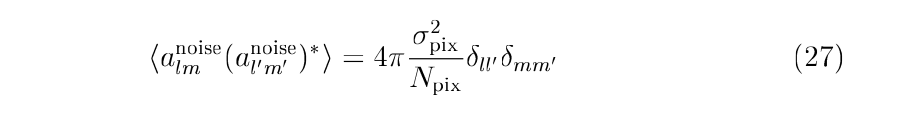

We will use the value of the sensitivity [$\mu {\text K} \cdot {\text arcmin} $] for the Simons Observatory Large Aperture Telescope (LAT) from Table 4 (Ballardini et al., 2025) to replace with $\sigma ^2_{\text pix}$ in Eq. (27).

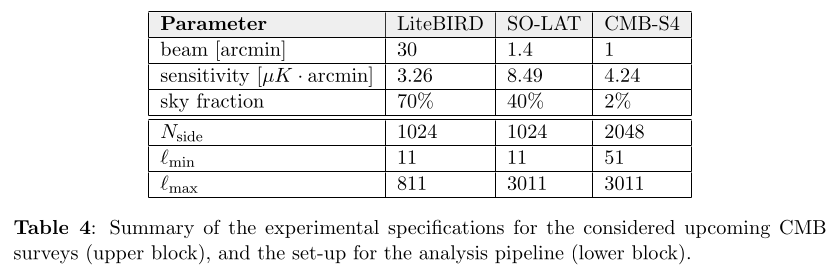

$N_{side} = 512$

$N_{pix} = 12N^2_{side} = 12 \times 512^2 = 3145728$

SO LAT sensiticity: $\sigma = 8.49 \, \mu K \cdot arcmin$

So, the noise amplitude is $N_{\ell} = 4 \pi \frac {\sigma^2}{N_{\text{pix}}}\, .$



#### Step 1: Convert arcmin -> radians

$\text{1 arcmin} = \frac {\pi}{180 \cdot 60} = 2.908882 \times 10^{-4} \, \text{rad}$

So:

$\sigma = 8.49 \times 2.908882 \times 10^{-4} = 2.4696 \times 10^{-3} \mu K \cdot rad$

#### Step 2: Square $\sigma$

$\sigma^2 = (2.4696 \times 10^{-3})^2 = 6.0991 \times 10^{-6} \mu K^2$

#### Step 3: Plug into Eq. (27)

$N_{\ell} = 4 \pi \frac {6.0991 \times 10^{-6}}{3145728}$

$N_{\ell} = 2.43 \times 10^{-11} \mu K^2$

The noise $C_l$ amplitude: $C_l^{noise} = 2.43 \times 10^{-11} \mu K^2$

Valid for: $2 \leq \ell \geq 1024$



### Creating a file of power spectra

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
%matplotlib inline

In [13]:
nside = 512
lmin = 2
lmax = 2 * nside

noise_amp = 2.43e-11  # microKelvin^2, computed from Lloyd Knox, 1995, Equation (27) and Ballardini et al., 2025, Table 4

ell = np.arange(lmin, lmax + 1, dtype=int)  

Cl_tt = noise_amp * np.ones_like(ell, dtype=float)
Cl_ee = noise_amp * np.ones_like(ell, dtype=float)
Cl_bb = noise_amp * np.ones_like(ell, dtype=float)
Cl_te = np.zeros_like(ell, dtype=float) # debiased: noise_TE = 0

# Stack them
spectra = np.column_stack((ell, Cl_tt, Cl_ee, Cl_bb, Cl_te))

# Save with ell as integer and Cls in scientific notation
np.savetxt("noise_Cls_SO_LAT_nside512.dat", spectra,
           header="l  Cl_TT  Cl_EE  Cl_BB Cl_TE", 
           fmt="%d %.18e %.18e %.18e %.18e")  # first column as integer

cls = [Cl_tt, Cl_ee, Cl_bb, Cl_te]

print("File written: noise_Cls_SO_LAT_nside512.dat")


File written: noise_Cls_SO_LAT_nside512.dat


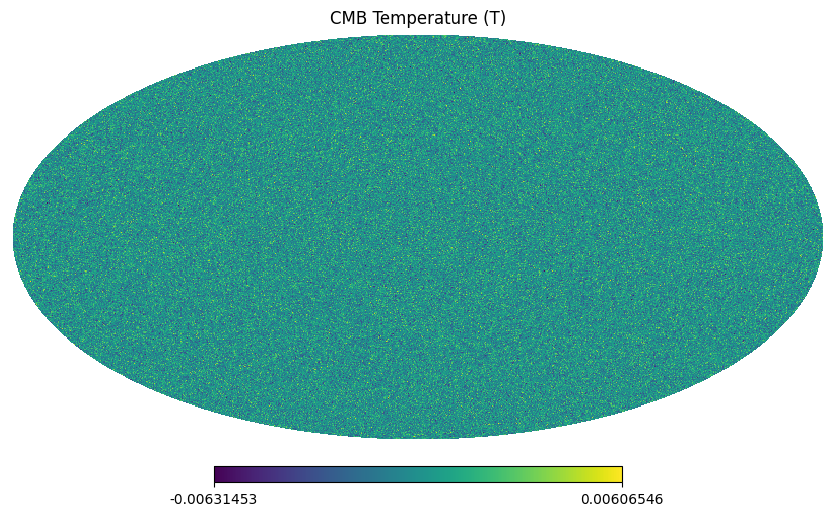

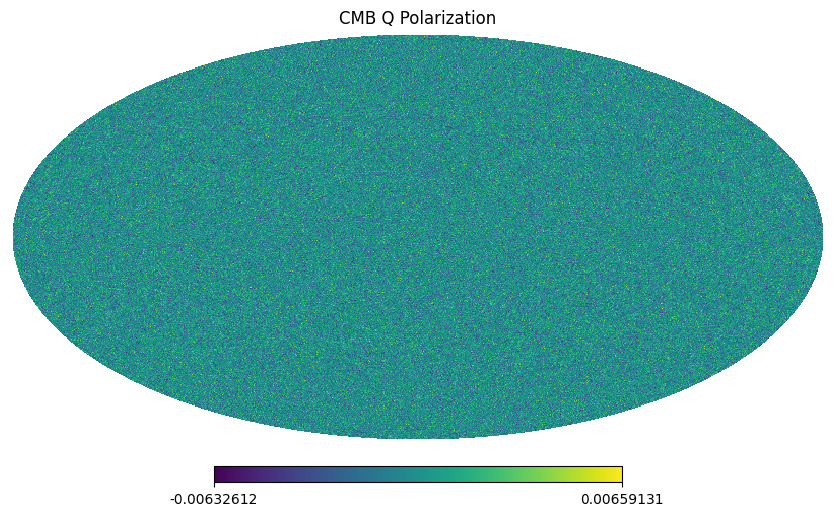

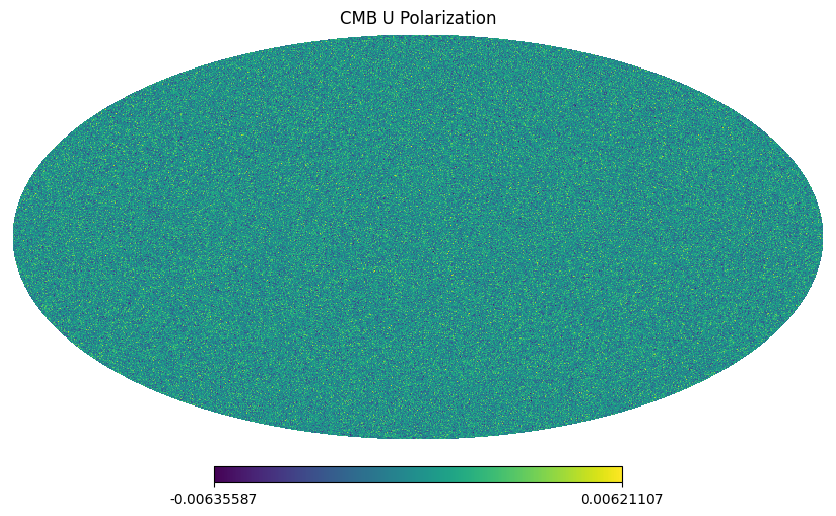

In [4]:
# Generate T, Q, U maps
TQU_map = hp.synfast(cls, nside=nside, lmax=lmax, pol=True, new=True)

# Plotting the maps
hp.mollview(TQU_map[0], title="CMB Temperature (T)")
hp.mollview(TQU_map[1], title="CMB Q Polarization")
hp.mollview(TQU_map[2], title="CMB U Polarization")
plt.show()


In [5]:
# Create containers to store the simulated spectra
cls_TT, cls_EE, cls_BB = [], [], []
cls_TE, cls_TB, cls_EB = [], [], []

# Simulate the maps and compute the spectra
num_sims = 100
for i in range(num_sims):
    TQU_map = hp.synfast(cls, nside=nside, lmax=lmax, pol=True, new=True)
    cl = hp.anafast(TQU_map, lmax=lmax, pol=True)
    cls_TT.append(cl[0])
    cls_EE.append(cl[1])
    cls_BB.append(cl[2])
    cls_TE.append(cl[3])
    cls_EB.append(cl[4])
    cls_TB.append(cl[5])

print("Generated 100 noise-only T/Q/U simulations.")

Generated 100 noise-only T/Q/U simulations.


In [6]:
cls_TT = np.array(cls_TT); cls_EE = np.array(cls_EE); cls_BB = np.array(cls_BB)
cls_TE = np.array(cls_TE); cls_EB = np.array(cls_EB); cls_TB = np.array(cls_TB)

In [7]:
# Compute the mean & std of the simulated spectra:
def mean_and_err(arr):
    arr = np.array(arr)
    return np.mean(arr, axis=0), np.std(arr, axis=0, ddof=1) / np.sqrt(num_sims)

mean_TT, err_TT = mean_and_err(cls_TT)
mean_EE, err_EE = mean_and_err(cls_EE)
mean_BB, err_BB = mean_and_err(cls_BB)
mean_TE, err_TE = mean_and_err(cls_TE)
mean_EB, err_EB = mean_and_err(cls_EB)
mean_TB, err_TB = mean_and_err(cls_TB)

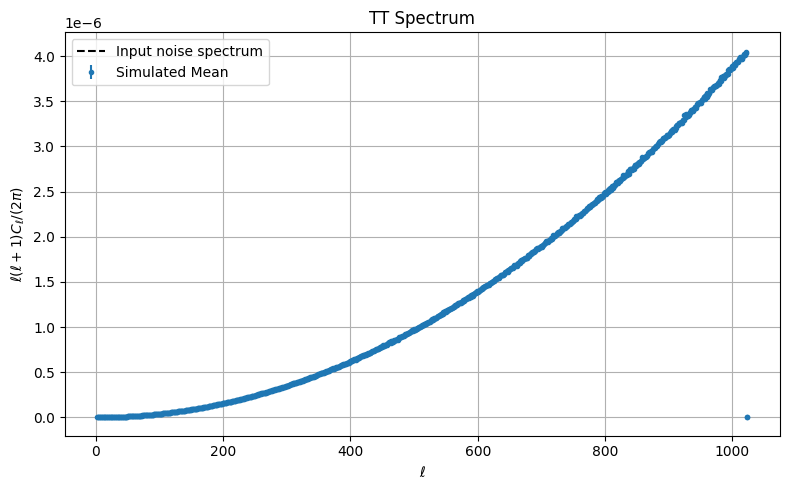

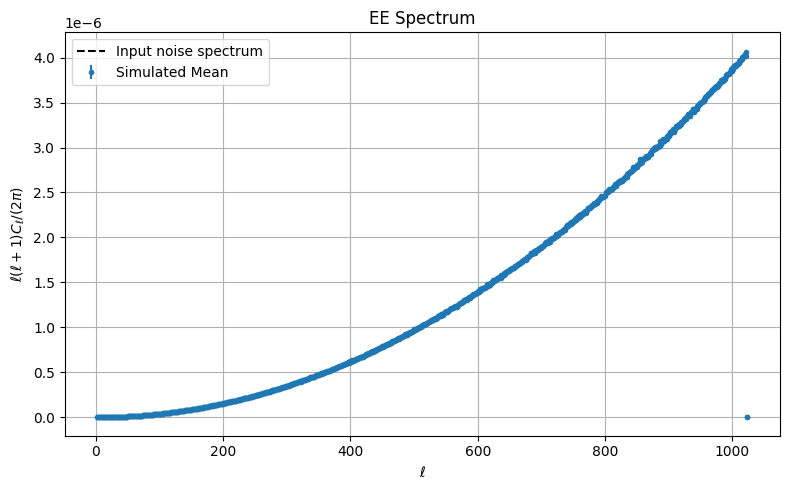

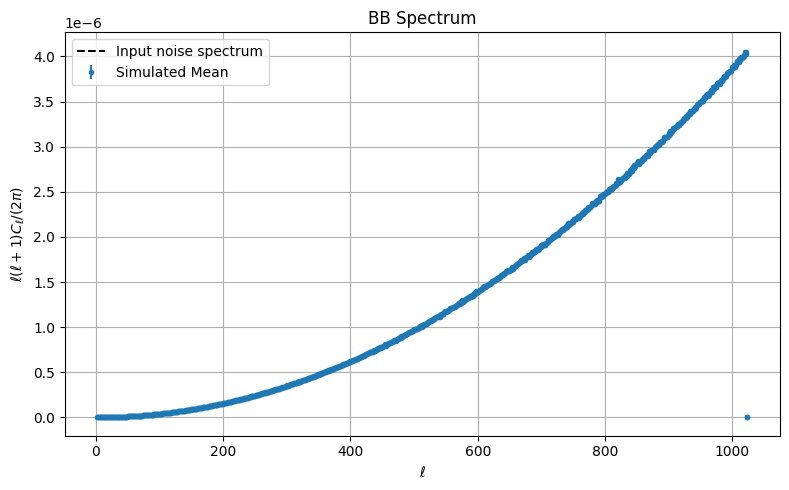

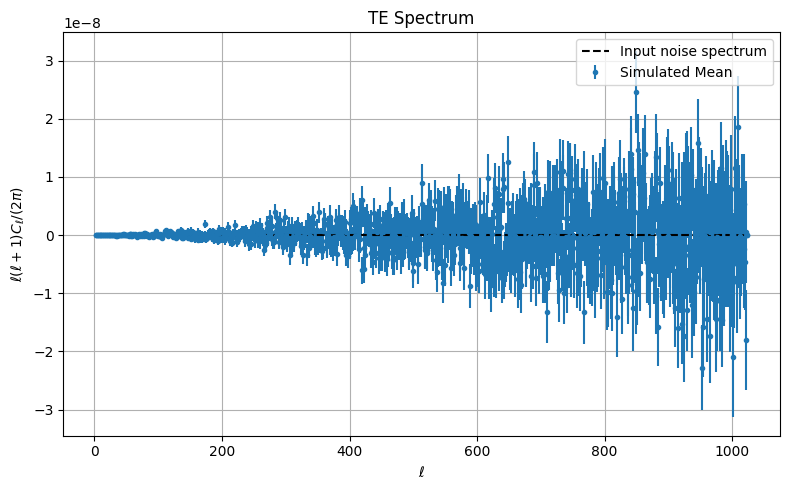

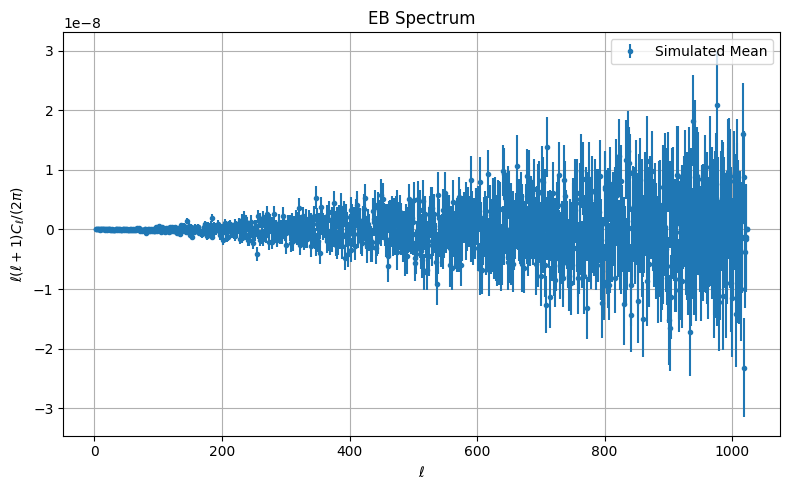

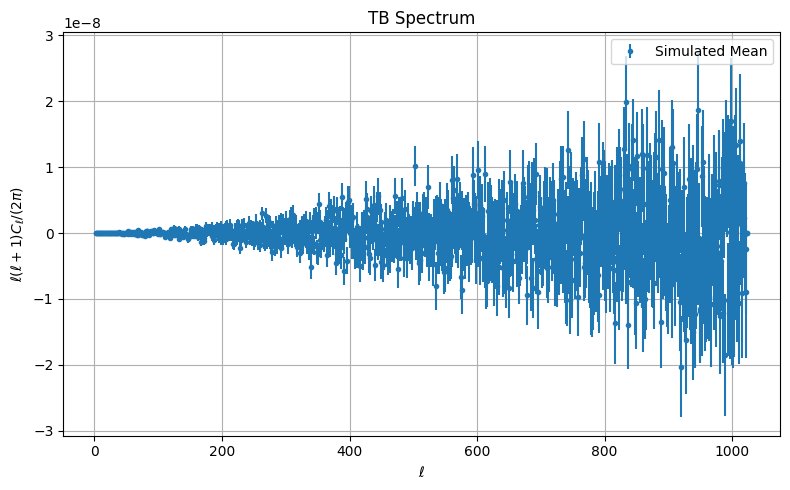

In [8]:
# Plot the comparison between the input noise power spectra and the simulated spectra


ell = np.arange(lmin, lmax + 1, dtype=int)  

def plot_spectrum(ell, mean, err, cl_input, label):
    plt.figure(figsize=(8,5))
    factor = ell * (ell + 1) / (2 * np.pi)
    plt.errorbar(ell, factor * mean[2:], factor * err[2:], fmt='.', label='Simulated Mean')
    if cl_input is not None:
        plt.plot(ell, factor * cl_input, 'k--', label='Input noise spectrum')
    plt.xlabel(r'$\ell$')
    plt.ylabel(r'$\ell(\ell+1)C_\ell/(2\pi)$')
    plt.title(f'{label} Spectrum')
    plt.legend(); plt.grid(True); plt.tight_layout()
    plt.show()


plot_spectrum(ell, mean_TT, err_TT, Cl_tt, 'TT')
plot_spectrum(ell, mean_EE, err_EE, Cl_ee, 'EE')
plot_spectrum(ell, mean_BB, err_BB, Cl_bb, 'BB')
plot_spectrum(ell, mean_TE, err_TE, Cl_te, 'TE')
plot_spectrum(ell, mean_EB, err_EB, None, 'EB')
plot_spectrum(ell, mean_TB, err_TB, None, 'TB')


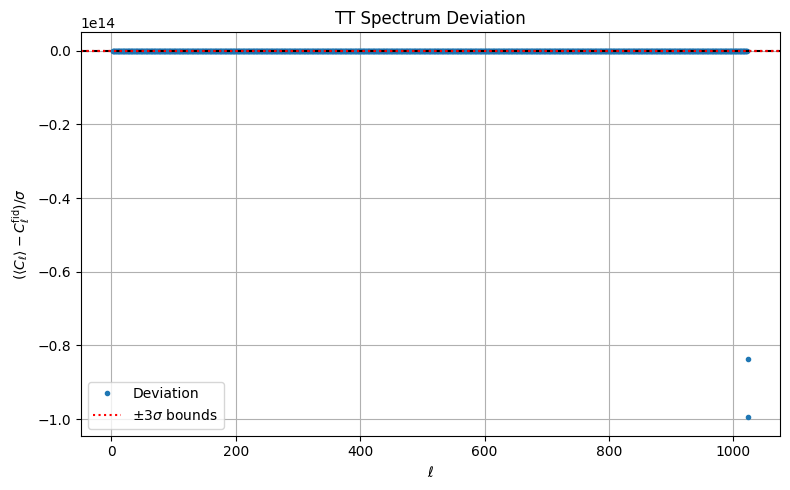

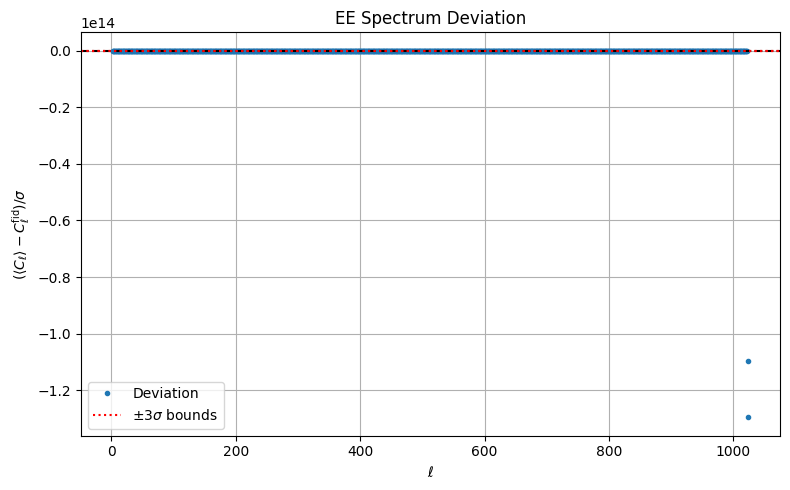

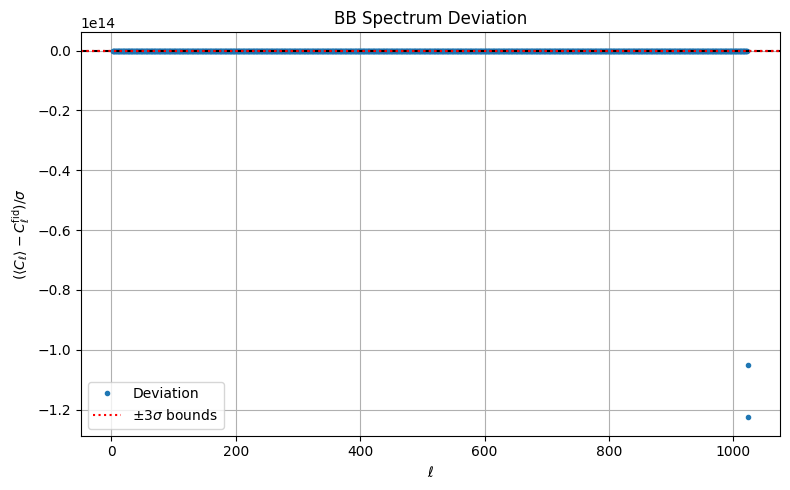

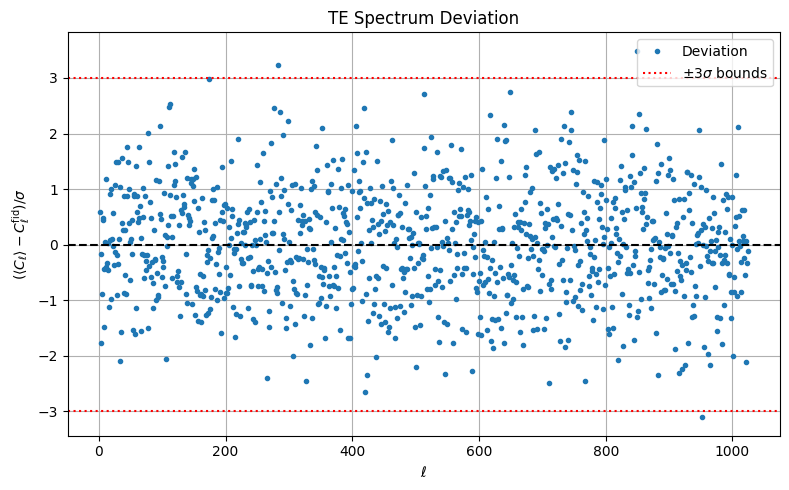

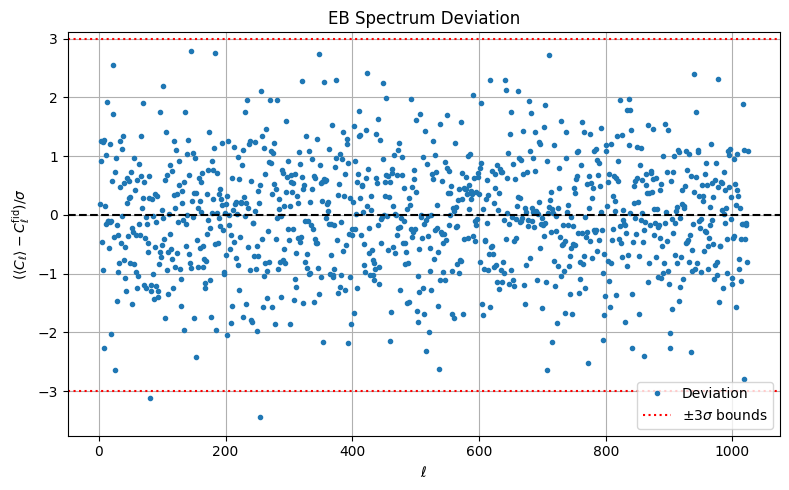

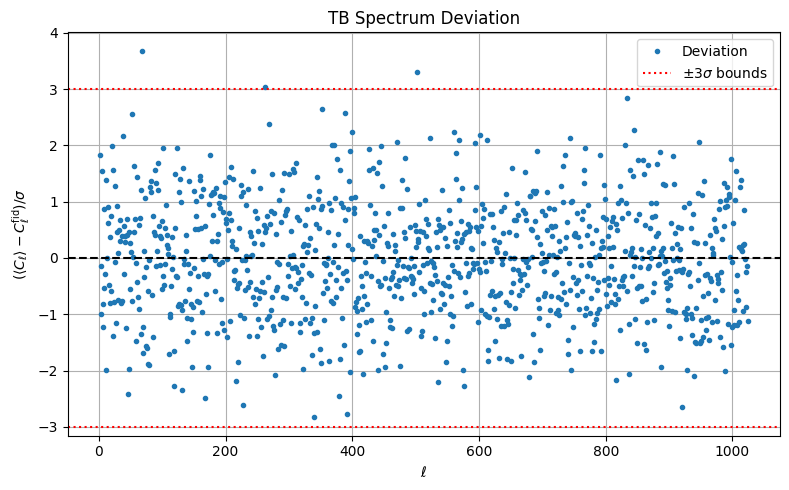

In [9]:
# Compute deviations in units of sigma

def compute_deviation(mean, err, fid, label):
    with np.errstate(divide='ignore', invalid='ignore'):
        deviation = (mean - fid) / err
        deviation[err == 0] = 0  # Avoid NaNs/Infs where err = 0
    return deviation

dev_TT = compute_deviation(mean_TT[2:], err_TT[2:], Cl_tt, 'TT')
dev_EE = compute_deviation(mean_EE[2:], err_EE[2:], Cl_ee, 'EE')
dev_BB = compute_deviation(mean_BB[2:], err_BB[2:], Cl_bb, 'BB')
dev_TE = compute_deviation(mean_TE[2:], err_TE[2:], Cl_te, 'TE')
dev_EB = compute_deviation(mean_EB[2:], err_EB[2:], np.zeros_like(mean_EB[2:]), 'EB')
dev_TB = compute_deviation(mean_TB[2:], err_TB[2:], np.zeros_like(mean_TB[2:]), 'TB')


# Plot the Deviations
def plot_deviation(ell, deviation, label):
    plt.figure(figsize=(8, 5))
    plt.plot(ell, deviation, '.', label='Deviation')
    plt.axhline(0, color='black', linestyle='--')
    plt.axhline(3, color='red', linestyle=':', label=r'$\pm3\sigma$ bounds')
    plt.axhline(-3, color='red', linestyle=':')
    plt.xlabel(r'$\ell$')
    plt.ylabel(r'$(\langle C_\ell \rangle - C_\ell^\mathrm{fid})/\sigma$')
    plt.title(f'{label} Spectrum Deviation')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_deviation(ell, dev_TT, 'TT')
plot_deviation(ell, dev_EE, 'EE')
plot_deviation(ell, dev_BB, 'BB')
plot_deviation(ell, dev_TE, 'TE')
plot_deviation(ell, dev_EB, 'EB')
plot_deviation(ell, dev_TB, 'TB')

